# Install Missing Dependencies

In [3]:
!pip install tensorflow-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00a 0:00:01


In [5]:
# Must be tensorflow text 2.9.0 since the Paperspace
# environment uses tensorflow 2.9.1
!pip install tensorflow-text==2.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 4.6 MB/s eta 0:00:0000:0100:01


In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from load_data import load_data
import pretrained_bert_map

In [8]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [9]:
tf.get_logger().setLevel('ERROR')

In [12]:
train_ds, val_ds, test_ds, class_names = load_data('data/text_only')

Found 1582 files belonging to 2 classes.
Using 1266 files for training.
Found 1582 files belonging to 2 classes.
Using 316 files for validation.
Found 396 files belonging to 2 classes.


In [13]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'meet hillary clintons secretary of state send a  million check to iran october   daniel greenfield daniel greenfield a shillman journalism fellow at the freedom center is a new york writer focusing on radical islam september   has come and gone countless bodies lie scattered in fragments around where two of the countrys tallest skyscrapers once stood some have burned to ash others had their throats slashed by islamic terrorists still others fought and died on a plane to prevent another islamic terror attack from taking place but joe has an idea joe is a guy with lots of big ideas and this one is a real doozy the senator from delaware has come a long way since his days as a sixties shyster drumming up business in wilmington his formerly bald head is covered in hair so shiny is gleams under neon lights his teeth are capped and shine almost as brightly after a generation holding down a squeaky seat in the senate seniority makes him a man to be reckoned with and therefore a man t

2024-03-07 00:38:32.936397: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

tfhub_handle_encoder = pretrained_bert_map.map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = pretrained_bert_map.map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Preprocessing
Tensorflow Hub does this all behind the scenes, apparently

In [15]:
bert_preprocess_model = hub.KerasLayer(
    tfhub_handle_preprocess
    # arguments={'seq_length': 256}
)

Test the preprocessing with  some input text

In [16]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using BERT Model
Before using BERT, check it's outputs

In [17]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

2024-03-07 00:39:33.209150: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62509056 exceeds 10% of free system memory.


In [18]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.18611865  0.3667382   0.15233754  0.6550446
  0.9681154  -0.948627    0.00216129 -0.9877731   0.06842719 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894631   0.3432125   0.33231503 ...  0.21300879  0.71020824
  -0.05771083]
 [-0.28741956  0.31981033 -0.23018478 ...  0.58455044 -0.21329702
   0.72692096]
 [-0.66156983  0.68876874 -0.87432986 ...  0.10877332 -0.26173213
   0.4785546 ]
 ...
 [-0.22561109 -0.2892557  -0.07064363 ...  0.47566098  0.8327722
   0.40025353]
 [-0.29824188 -0.27473086 -0.05450502 ...  0.48849785  1.0955354
   0.18163365]
 [-0.4437817   0.00930776  0.07223777 ...  0.17290121  1.1833248
   0.07898013]]


Build the classifier model

In [19]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    # `activation=None` used rather than `activation=sigmoid` because it 
    # helps avoid floating point rounding errors when using binary 
    # cross-entropy as the loss function later.
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)


Check that the model runs with the output of the preprocessing model

In [20]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

2024-03-07 00:39:57.986032: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62509056 exceeds 10% of free system memory.


tf.Tensor([[0.47958493]], shape=(1, 1), dtype=float32)


In [21]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Train Model

In [22]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [23]:
optimizer = tf.keras.optimizers.Adam()

In [24]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [25]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [26]:
print(f'Training model with {tfhub_handle_encoder}')

epochs = 5

history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
40/40 [==============================] - 23s 341ms/step - loss: 0.7440 - binary_accuracy: 0.5316 - val_loss: 0.6944 - val_binary_accuracy: 0.3386
Epoch 2/5
40/40 [==============================] - 12s 294ms/step - loss: 0.7123 - binary_accuracy: 0.4803 - val_loss: 0.6490 - val_binary_accuracy: 0.3386
Epoch 3/5
40/40 [==============================] - 11s 264ms/step - loss: 0.6764 - binary_accuracy: 0.5371 - val_loss: 0.6455 - val_binary_accuracy: 0.3386
Epoch 4/5
40/40 [==============================] - 11s 275ms/step - loss: 0.7196 - binary_accuracy: 0.4818 - val_loss: 0.6425 - val_binary_accuracy: 0.6614
Epoch 5/5
40/40 [==============================] - 11s 272ms/step - loss: 0.7116 - binary_accuracy: 0.4637 - val_loss: 0.6401 - val_binary_accuracy: 0.6614


## Evaluate Model

In [27]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

13/13 [==============================] - 5s 167ms/step - loss: 0.6713 - binary_accuracy: 0.6162
Loss: 0.6712573766708374
Accuracy: 0.6161616444587708


In [28]:
def plot_curves(history):
    print(history.history.keys())

    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']


    plt.figure(figsize=(8, 16))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training and Validation Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')

    plt.xlabel('epoch')
    plt.show()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


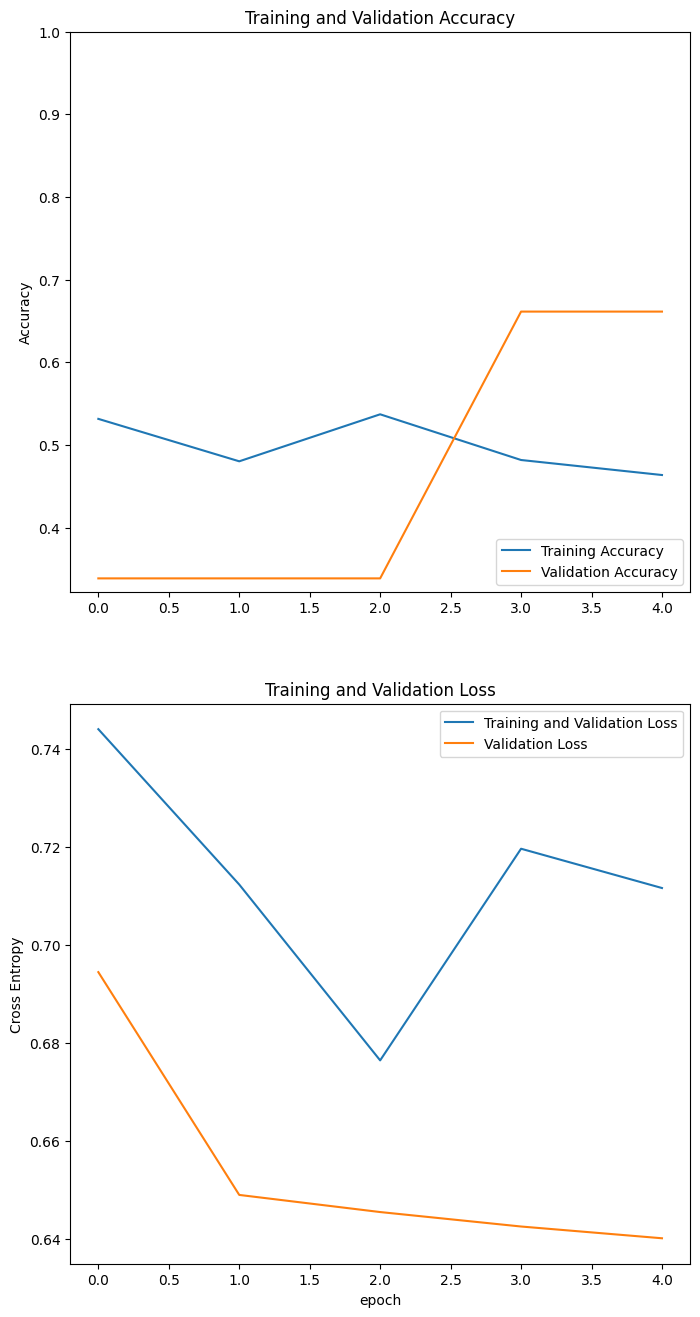

In [29]:
plot_curves(history)

In [30]:
# save model
tf.keras.models.save_model(classifier_model, f"clf_{bert_model_name}_single_node_op.h5")


2024-03-07 00:43:53.498642: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62509056 exceeds 10% of free system memory.
2024-03-07 00:43:53.868671: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62509056 exceeds 10% of free system memory.
2024-03-07 00:43:54.068639: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62509056 exceeds 10% of free system memory.
